In [2]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import transforms as T

from typing import List

AttributeError: type object 'torch._C._onnx.TensorProtoDataType' has no attribute 'FLOAT8E5M2FNUZ'

In [ ]:
CLASSES = ["licence_plate"]

GDRIVE_DATASET_PATH = "/Users/mgx/Library/CloudStorage/GoogleDrive-skatorlp@googlemail.com/Meine Ablage/Licence Plate Detection Dataset v1"

: 

In [ ]:
def get_data_dicts(directory: str, classes: list) -> List[dict]:
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith(".json")]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["height"] = img_anns['imageHeight']  # IMAGE_DIMENSIONS[0]
        record["width"] = img_anns['imageWidth']  # IMAGE_DIMENSIONS[1]
        record["image_id"] = filename + "_numberplate_only"

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno["points"]]
            py = [a[1] for a in anno["points"]]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno["label"]),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

: 

In [ ]:
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("licence_plate_detection_" + d, lambda d=d: get_data_dicts(GDRIVE_DATASET_PATH + d, CLASSES))
    MetadataCatalog.get("licence_plate_detection_" + d).set(thing_classes=CLASSES)

licence_plate_detection_metadata = MetadataCatalog.get("licence_plate_detection_train")

dataset_dicts = get_data_dicts(os.path.join(GDRIVE_DATASET_PATH, "train"), CLASSES)

: 

In [ ]:
#for d in random.sample(dataset_dicts, 1):
#  img = cv2.imread(d["file_name"])
#  visualizer = Visualizer(img[:,:,::-1], metadata=licence_plate_detection_metadata, scale=0.5)
#  out = visualizer.draw_dataset_dict(d)
#  cv2_imshow(out.get_image()[:,:,::-1])

: 

In [ ]:
from detectron2.data.transforms import Resize

train_augmentations = [
    T.ResizeShortestEdge(short_edge_length=512, max_size=512, sample_style='choice'),
    #T.RandomBrightness(0.5, 2),
    #T.RandomContrast(0.5, 2),
    #T.RandomSaturation(0.5, 2),
    #T.RandomFlip(0.5, horizontal=True, vertical=False)
]

: 

In [ ]:
from detectron2.engine.defaults import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetMapper

class LicencePlateTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR,"inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    @classmethod
    def build_train_loader(cls, cfg):
      #mapper = DatasetMapper(cfg, is_train=True, augmentations=[])
      mapper = DatasetMapper(cfg, is_train=True, augmentations=train_augmentations)
      return build_detection_train_loader(cfg, mapper=mapper)

: 

In [ ]:
#del trainer
torch.cuda.empty_cache()
cfg = get_cfg()

#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.DATASETS.TRAIN = ("licence_plate_detection_train",)
cfg.DATASETS.TEST = ("licence_plate_detection_val",)

cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 8

cfg.INPUT.MIN_SIZE_TRAIN = (512, )
cfg.INPUT.MAX_SIZE_TRAIN = (512, )

cfg.SOLVER.AMP.ENABLED = True

cfg.MODEL.DEVICE = "cuda"

cfg.SOLVER.IMS_PER_BATCH = 32
cfg.SOLVER.BASE_LR = 1e-2
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.LOG_PERIOD = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

cfg.SOLVER.CHECKPOINT_PERIOD = 100
cfg.OUTPUT_DIR = "checkpoints"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = LicencePlateTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

AssertionError: Torch not compiled with CUDA enabled

: 

# Evaluation

In [ ]:
cfg.MODEL_WEIGHTS = "output/mode_0000099.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)

[01/30 22:57:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


: 

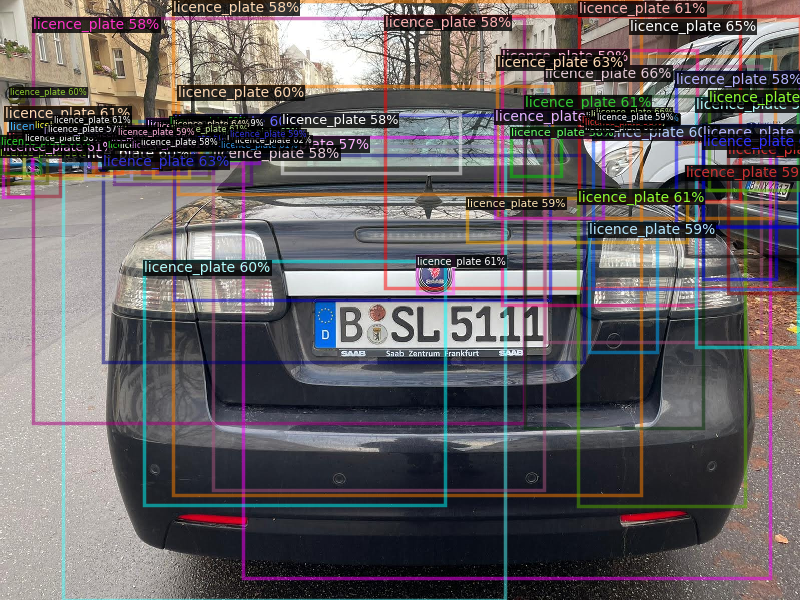

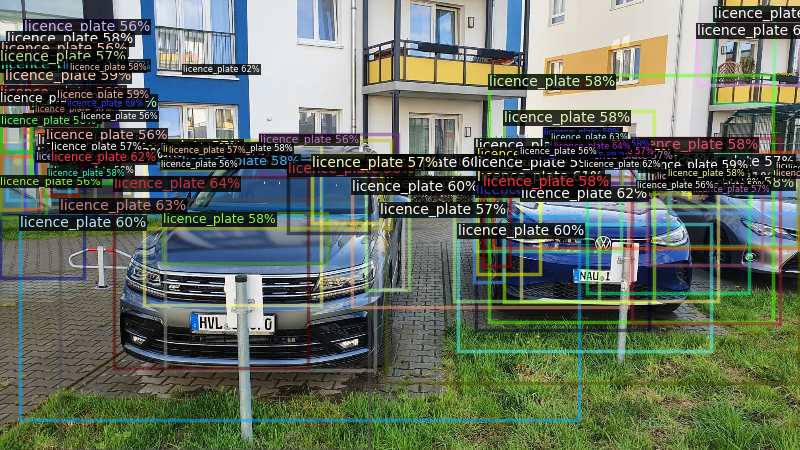

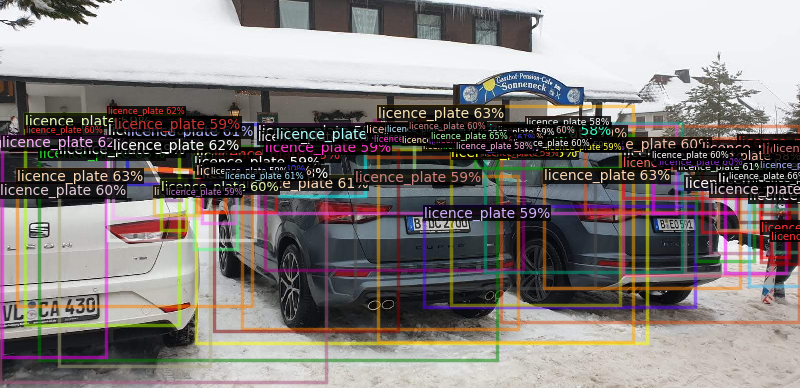

: 

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset = get_data_dicts(GDRIVE_DATASET_PATH + "val", CLASSES)

for d in random.sample(dataset, 3):
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)
  v = Visualizer(
      im[:,:, ::-1],
      metadata=licence_plate_detection_metadata,
      scale = 0.5
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:,:, ::-1])

: 